=== BASELINE MODELS WITH STATISTICAL ANALYSIS ===
Data shape: (5630, 39)
Features: 37
Target distribution:
Churn
0    4682
1     948
Name: count, dtype: int64
Churn rate: 0.168

Train set: (4504, 37), Churn rate: 0.168
Test set: (1126, 37), Churn rate: 0.169

1. BASELINE MODELS TRAINING

--- Logistic Regression ---
Accuracy: 0.8961
AUC: 0.8896
Average Precision: 0.7118
CV AUC: 0.8945 (+/- 0.0250)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       936
           1       0.76      0.55      0.64       190

    accuracy                           0.90      1126
   macro avg       0.84      0.76      0.79      1126
weighted avg       0.89      0.90      0.89      1126


--- Decision Tree ---
Accuracy: 0.8881
AUC: 0.8810
Average Precision: 0.6715
CV AUC: 0.8737 (+/- 0.0325)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.93       936
          

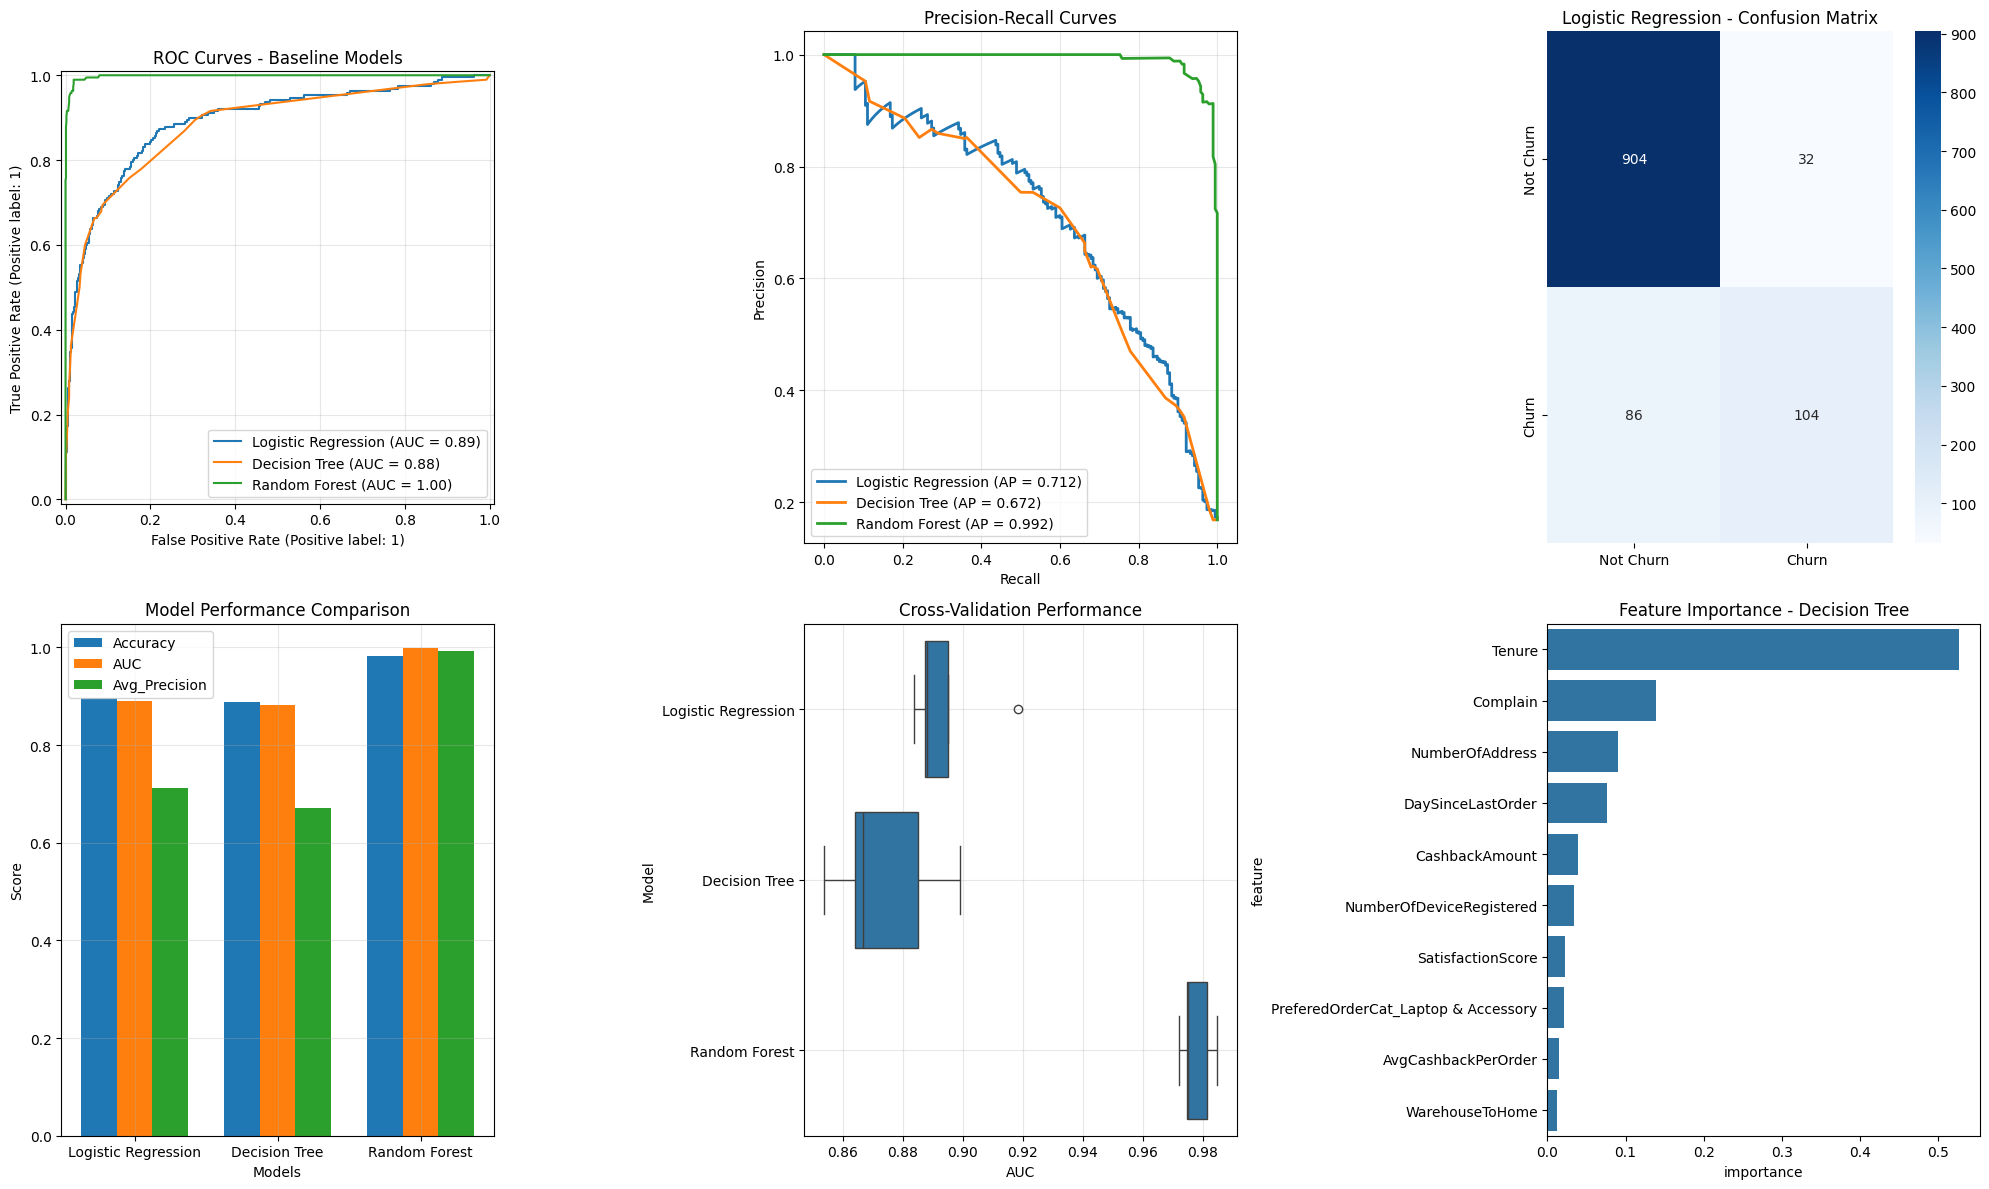


4. ERROR ANALYSIS
Logistic Regression misclassifications: 118
Samples where all models are correct: 960
Samples where all models are wrong: 14

5. STATISTICAL SIGNIFICANCE TESTING
Bootstrap Confidence Intervals (95%):

Logistic Regression:
  AUC: 0.8901 [0.8598, 0.9176]
  Accuracy: 0.8953 [0.8774, 0.9130]

Decision Tree:
  AUC: 0.8804 [0.8463, 0.9097]
  Accuracy: 0.8881 [0.8694, 0.9067]

Random Forest:
  AUC: 0.9982 [0.9967, 0.9993]
  Accuracy: 0.9824 [0.9742, 0.9893]

Pairwise Model Comparison (AUC):
Logistic Regression vs Decision Tree:
  Mean AUC: 0.8945 vs 0.8737
  t-statistic: 5.2771, p-value: 0.0062
  → Statistically significant difference (p < 0.05)

Logistic Regression vs Random Forest:
  Mean AUC: 0.8945 vs 0.9777
  t-statistic: -15.9605, p-value: 0.0001
  → Statistically significant difference (p < 0.05)

Decision Tree vs Random Forest:
  Mean AUC: 0.8737 vs 0.9777
  t-statistic: -16.2420, p-value: 0.0001
  → Statistically significant difference (p < 0.05)


6. BASELINE MODE

In [4]:
# Baseline Model with Statistical Analysis
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           precision_recall_curve, average_precision_score, RocCurveDisplay)
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')
from src.config.database import get_connection_string

print("=== BASELINE MODELS WITH STATISTICAL ANALYSIS ===")

# Load data
engine = create_engine(get_connection_string())
query = "SELECT * FROM ml_ready_features"
df = pd.read_sql(query, engine)

print(f"Data shape: {df.shape}")

# Prepare features and target
X = df.drop(['Churn', 'CustomerID'], axis=1)
y = df['Churn']

print(f"Features: {X.shape[1]}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Churn rate: {y.mean():.3f}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Churn rate: {y_train.mean():.3f}")
print(f"Test set: {X_test.shape}, Churn rate: {y_test.mean():.3f}")

# 1. Baseline Models
print("\n" + "="*50)
print("1. BASELINE MODELS TRAINING")
print("="*50)

baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

baseline_results = {}

# Train and evaluate baseline models
for name, model in baseline_models.items():
    print(f"\n--- {name} ---")
    
    # Train model
    if name == 'Logistic Regression':
        # Scale features for logistic regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = model.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Cross-validation
    if name == 'Logistic Regression':
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Store results
    baseline_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'avg_precision': avg_precision,
        'cv_scores': cv_scores,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'scaler': scaler if name == 'Logistic Regression' else None
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

# 2. Comprehensive Model Comparison
print("\n" + "="*50)
print("2. COMPREHENSIVE MODEL COMPARISON")
print("="*50)

# Create comparison dataframe
comparison_data = []
for name, results in baseline_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'AUC': results['auc'],
        'Avg_Precision': results['avg_precision'],
        'CV_AUC_Mean': results['cv_scores'].mean(),
        'CV_AUC_Std': results['cv_scores'].std()
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('AUC', ascending=False)
print("Model Comparison:")
print(comparison_df)

# 3. Visual Comparison
print("\n" + "="*50)
print("3. VISUAL COMPARISON")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# ROC Curves
for name, results in baseline_results.items():
    if name == 'Logistic Regression':
        RocCurveDisplay.from_estimator(results['model'], X_test_scaled, y_test, ax=axes[0,0], name=name)
    else:
        RocCurveDisplay.from_estimator(results['model'], X_test, y_test, ax=axes[0,0], name=name)
axes[0,0].set_title('ROC Curves - Baseline Models')
axes[0,0].grid(True, alpha=0.3)

# Precision-Recall Curves
for name, results in baseline_results.items():
    precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
    axes[0,1].plot(recall, precision, label=f'{name} (AP = {results["avg_precision"]:.3f})', linewidth=2)
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curves')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Confusion Matrices
for i, (name, results) in enumerate(baseline_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,2], 
                xticklabels=['Not Churn', 'Churn'],
                yticklabels=['Not Churn', 'Churn'])
    axes[0,2].set_title(f'{name} - Confusion Matrix')
    break  # Only show first model for space

# Performance Metrics Comparison
metrics = ['Accuracy', 'AUC', 'Avg_Precision']
x_pos = np.arange(len(baseline_models))
width = 0.25

for i, metric in enumerate(metrics):
    values = [baseline_results[name][metric.lower().replace(' ', '_')] for name in baseline_results]
    axes[1,0].bar(x_pos + i*width, values, width, label=metric)

axes[1,0].set_xlabel('Models')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Model Performance Comparison')
axes[1,0].set_xticks(x_pos + width)
axes[1,0].set_xticklabels(list(baseline_results.keys()))
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Cross-Validation Results
cv_data = []
for name, results in baseline_results.items():
    for fold, score in enumerate(results['cv_scores']):
        cv_data.append({'Model': name, 'Fold': fold+1, 'AUC': score})
cv_df = pd.DataFrame(cv_data)

sns.boxplot(data=cv_df, x='AUC', y='Model', ax=axes[1,1])
axes[1,1].set_title('Cross-Validation Performance')
axes[1,1].grid(True, alpha=0.3)

# Feature Importance (for tree-based models)
for name, results in baseline_results.items():
    if hasattr(results['model'], 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': results['model'].feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        sns.barplot(data=feature_importance, x='importance', y='feature', ax=axes[1,2])
        axes[1,2].set_title(f'Feature Importance - {name}')
        break

plt.tight_layout()
plt.show()

# 4. Error Analysis
print("\n" + "="*50)
print("4. ERROR ANALYSIS")
print("="*50)

# Analyze misclassifications
error_analysis = pd.DataFrame({
    'Actual': y_test,
    'Logistic_Regression': baseline_results['Logistic Regression']['predictions'],
    'Decision_Tree': baseline_results['Decision Tree']['predictions'],
    'Random_Forest': baseline_results['Random Forest']['predictions']
})

# Misclassification patterns
misclassified = error_analysis[error_analysis['Actual'] != error_analysis['Logistic_Regression']]
print(f"Logistic Regression misclassifications: {len(misclassified)}")

# Analyze where models agree/disagree
agreement_analysis = pd.DataFrame()
agreement_analysis['All_Correct'] = (
    (error_analysis['Actual'] == error_analysis['Logistic_Regression']) &
    (error_analysis['Actual'] == error_analysis['Decision_Tree']) &
    (error_analysis['Actual'] == error_analysis['Random_Forest'])
)
agreement_analysis['All_Wrong'] = (
    (error_analysis['Actual'] != error_analysis['Logistic_Regression']) &
    (error_analysis['Actual'] != error_analysis['Decision_Tree']) &
    (error_analysis['Actual'] != error_analysis['Random_Forest'])
)

print(f"Samples where all models are correct: {agreement_analysis['All_Correct'].sum()}")
print(f"Samples where all models are wrong: {agreement_analysis['All_Wrong'].sum()}")

# 5. Statistical Significance Testing
print("\n" + "="*50)
print("5. STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Bootstrap analysis for confidence intervals
def bootstrap_metrics(y_true, y_pred_proba, n_bootstrap=1000):
    """Calculate bootstrap confidence intervals for metrics"""
    n_samples = len(y_true)
    auc_scores = []
    accuracy_scores = []
    
    for _ in range(n_bootstrap):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
            
        # AUC
        auc = roc_auc_score(y_true.iloc[indices], y_pred_proba[indices])
        auc_scores.append(auc)
        
        # Accuracy
        y_pred = (y_pred_proba[indices] > 0.5).astype(int)
        accuracy = np.mean(y_pred == y_true.iloc[indices])
        accuracy_scores.append(accuracy)
    
    return {
        'auc_mean': np.mean(auc_scores),
        'auc_ci': np.percentile(auc_scores, [2.5, 97.5]),
        'accuracy_mean': np.mean(accuracy_scores),
        'accuracy_ci': np.percentile(accuracy_scores, [2.5, 97.5])
    }

print("Bootstrap Confidence Intervals (95%):")
for name, results in baseline_results.items():
    bootstrap_results = bootstrap_metrics(y_test, results['probabilities'])
    print(f"\n{name}:")
    print(f"  AUC: {bootstrap_results['auc_mean']:.4f} [{bootstrap_results['auc_ci'][0]:.4f}, {bootstrap_results['auc_ci'][1]:.4f}]")
    print(f"  Accuracy: {bootstrap_results['accuracy_mean']:.4f} [{bootstrap_results['accuracy_ci'][0]:.4f}, {bootstrap_results['accuracy_ci'][1]:.4f}]")

# Statistical test for model comparison
from scipy.stats import ttest_rel

print("\nPairwise Model Comparison (AUC):")
models_list = list(baseline_results.keys())
for i in range(len(models_list)):
    for j in range(i+1, len(models_list)):
        model1 = models_list[i]
        model2 = models_list[j]
        
        # Compare cross-validation scores
        scores1 = baseline_results[model1]['cv_scores']
        scores2 = baseline_results[model2]['cv_scores']
        
        t_stat, p_value = ttest_rel(scores1, scores2)
        
        print(f"{model1} vs {model2}:")
        print(f"  Mean AUC: {scores1.mean():.4f} vs {scores2.mean():.4f}")
        print(f"  t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"  → Statistically significant difference (p < 0.05)")
        else:
            print(f"  → No significant difference")
        print()

# 6. Baseline Conclusion
print("\n" + "="*50)
print("6. BASELINE MODEL SELECTION")
print("="*50)

best_baseline = comparison_df.iloc[0]
print(f"🎯 BEST BASELINE MODEL: {best_baseline['Model']}")
print(f"📊 Performance:")
print(f"   - AUC: {best_baseline['AUC']:.4f}")
print(f"   - Accuracy: {best_baseline['Accuracy']:.4f}")
print(f"   - Average Precision: {best_baseline['Avg_Precision']:.4f}")

# Save baseline results
import joblib
import os
os.makedirs('../models/baseline', exist_ok=True)

joblib.dump(baseline_results[best_baseline['Model']]['model'], '../models/baseline/best_baseline_model.pkl')
print("✓ Best baseline model saved to models/baseline/")

print("\n✅ BASELINE MODEL ANALYSIS COMPLETED!")
print("\nNext steps:")
print("1. Proceed to advanced model experiments")
print("2. Hyperparameter tuning for best baseline")
print("3. Ensemble methods exploration")